This notebook has been developed to show how coding with brightway while still using the Activity Browser looks like.

More information on the seminars can be found [here](https://adelinejerome.github.io/seminars-for-esa/).

# Importing packages

In [15]:
# Brightway
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa

# Others
import pandas as pd
import matplotlib.pyplot as plt

# Open a project and a database

In [16]:
bd.projects.set_current("brightway2_test")

In [17]:
motor_db = bd.Database("motor_case")

# After modelling on the AB

## Selection of impact assessment methods

Global warming EF 3.1:

In [18]:
gw_method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')

Crustal scarcity indicator:

In [19]:
csi_method = [method for method in bd.methods if "Crustal" in str(method)][0]

## Selection of functional unit

In [20]:
# Value of the lifetime
lifetime = 20 #years

In [21]:
functional_unit = {motor_db.get("motor EoL treatment"): 1/lifetime}

## Impact assessment

In [22]:
def lca_results(fu, list_methods):
    list_units = [bd.methods.get(method)["unit"] for method in list_methods]
    lca = bc.LCA(demand=fu, method=list_methods[0])
    lca.lci()
    lca.lcia()
    list_scores = [lca.score]
    for method in list_methods[1:]:
        lca.switch_method(method)
        lca.lcia()
        list_scores.append(lca.score)
    return pd.DataFrame({"score": list_scores, "unit": list_units, "method": list_methods})

In [23]:
lca_results(functional_unit, [gw_method, csi_method])

,score,unit,method
0,4.136072e+05,kg CO2-Eq,"(EF v3.1, climate change, global warming poten..."
1,7.013956e+07,kg Si-Eq,"(Crustal Scarcity Indicator 2020, material res..."


## Figures

## Generate the data to be plotted

In [24]:
def table_recursive_multi_calculation_dbcut(activity, lcia_methods, amount=1, level=0, max_level=3, db_activity='motor_case', db_cut=['ecoinvent', 'biosphere']):
    """
    Returns a table (DataFrame) with the contribution tree for a given activity and various LCIA methods.
    The contribution tree does not contain activities if they are from a database in db_cut (to avoid 
    having details on ecoinvent datasets and to stay in my own model) and has the maximum level max_level.
    Columns for the returned table: level, activity, database, and str(method) for all LCIA method explored.
    """
    
    lca_score = lca_results({activity: amount}, lcia_methods)
    table = pd.DataFrame([[level, activity["name"], db_activity]+ list(lca_score["score"])], columns=["level", "activity", "database"]+[str(m) for m in lcia_methods])
    if level < max_level:
        for exc in activity.technosphere():
            db_exc = exc.input['database']
            go_forward = True
            for stop_word in db_cut:
                if stop_word in db_exc:
                    go_forward = False
            if go_forward:
                table = pd.concat([table, table_recursive_multi_calculation_dbcut(
                    activity=exc.input, 
                    lcia_methods=lcia_methods, 
                    amount=amount * exc['amount'], 
                    level=level + 1, 
                    max_level=max_level,
                    db_activity = db_exc
                )], ignore_index=True)
    return table

In [25]:
table_results = table_recursive_multi_calculation_dbcut(
    activity = motor_db.get("motor EoL treatment"), 
    lcia_methods=[gw_method, csi_method], 
    amount = 1/lifetime,
    max_level = 3
)

### Select characteristics for the figure

In [26]:
own_colors = {
    "motor production":"#1f78b4", #blue
    "motor use":"#969696", #gray
    "motor EoL treatment": "#41ae76", #green
    "motor testing":"#fff7bc" #yellow
}

### Figure generation

In [27]:
def basic_bar_chart(table_results, legend_x_axis, own_colors=own_colors):
    table_figure = table_results.set_index(table_results["activity"])
    number_methods = table_figure.shape[1] - 3

    fig, ax = plt.subplots(1, number_methods)
    x_axis = [0]

    for n_fig, method in enumerate(table_figure.columns[3:]):
        for activity in table_figure.index:
            if n_fig == 0:
                ax[n_fig].bar(
                    x_axis, 
                    table_figure.loc[activity, method], 
                    label=activity, 
                    color=own_colors[activity]
                )
            else:
                ax[n_fig].bar(
                    x_axis, 
                    table_figure.loc[activity, method], 
                    color=own_colors[activity]
                )
    
    fig.tight_layout()
    for n_fig in range(number_methods):
        ax[n_fig].grid(True, axis='y', linewidth=0.4)
        ax[n_fig].set_xticks(x_axis)
        ax[n_fig].set_xticklabels([legend_x_axis[n_fig]], fontsize=14)
    
    fig.legend(loc='lower center', ncol=5)
    plt.subplots_adjust(bottom=0.15)
    
    return plt.show()

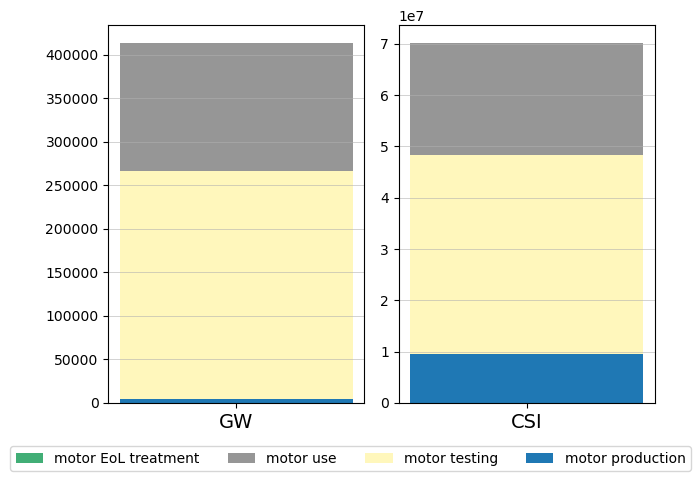

In [28]:
basic_bar_chart(
    table_results,
    ["GW", "CSI"]
)